## Interspecies machine learning: using animal training data to classify humans neurons 

In [36]:
import pandas as pd
from pylmeasure import *
import matplotlib.pyplot as plt
from pprint import pprint as pp
import seaborn as sns

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

# 1. Introduction
Animal neuronal data is widely available online, mainly because most neuroscientific experiments are performed on animals (they are dangerous and require brain material, so humans are not a popular choice).

Since human share common ancestors with other species, can we use these repositories of data to actually classify human neurons, as they might be similar in shape and structure? 

If this is true, large databases of neurons may be leveraged for human brain research.

## 1.1 Loading datasets

In [37]:
#When data is loaded and you see the cell type, you can observe that it is a list of usually two classes
#These are primary and secondary cell types (column = cell_type)
human_df = pd.read_csv('human_neurons')
human_df.head()

,neuron_name,neuron_id,surface,volume,bif_ampl_remote,soma_Surface,n_stems,n_bifs,n_branch,width,...,pathDistance,branch_Order,contraction,fragmentation,partition_asymmetry,pk_classic,bif_ampl_local,fractal_Dim,length,cell_type
0,H17-03-010-11-13-01_656411100_m,102399,2791.48,487.836,72.4360,332.975,3.0,15.0,33.0,105.300,...,503.237,5.0,0.890903,1495.0,0.594286,2.00000,86.7671,1.03135,1674.33,"['interneuron', 'Aspiny']"
1,H17-03-010-11-13-06_651089035_m,102400,28371.60,6418.630,58.0037,911.212,10.0,69.0,148.0,759.300,...,1163.650,12.0,0.923756,10448.0,0.477612,2.00000,66.7517,1.01848,13121.30,"['principal cell', 'Spiny']"
2,H17-03-011-11-04-05_650978964_m,102401,32648.50,5310.810,59.3831,576.503,8.0,105.0,218.0,813.359,...,1215.100,16.0,0.867798,17989.0,0.421518,2.00000,81.8977,1.04088,21365.40,"['principal cell', 'Spiny']"
3,H17-03-011-11-09-04_648981937_m,102402,22077.40,2635.900,77.0152,633.604,5.0,120.0,245.0,852.780,...,1311.270,20.0,0.890038,17156.0,0.630371,1.99076,76.0679,1.02556,20480.70,"['principal cell', 'Spiny']"
4,H17-06-005-12-15-01_605485782_m,102403,29832.50,2650.340,83.7322,475.183,7.0,193.0,393.0,807.692,...,1478.070,26.0,0.894317,29538.0,0.507338,2.01255,88.4040,1.02919,34251.30,"['interneuron', 'Aspiny']"


In [38]:
#This is a function that will separate this column into two columns
def separate_cells(df):
    cell_types_list = df['cell_type'].to_list()
    primary_cell_type_list = []
    secondary_cell_type_list = []
    for i in range(0,len(cell_types_list)):
        word_list = cell_types_list[i]
        word_list = word_list.strip('[]')
        word_list = word_list.strip('')
        word_list = word_list.split(',')
        word_list = [word.strip("''") for word in word_list]
        word_list = [word.lstrip(" '")for word in word_list]
        primary_cell_type_list.append(word_list[0].lower())
        if len(word_list) > 1:
            secondary_cell_type_list.append(word_list[1].lower())
        else:
            secondary_cell_type_list.append('none listed')
    df['primary_cell_type'] = primary_cell_type_list
    df['secondary_cell_type'] = secondary_cell_type_list
    df.drop('cell_type',1,inplace=True)
    return df

In [39]:
# Loading human data and transforming columns
human_df = pd.read_csv('human_neurons')
print('Number of rows for human neurons is ' + str(len(human_df)))
# I am coding the human species as a number 0
human_df['species'] = 0
human_df = separate_cells(human_df)

Number of rows for human neurons is 7150


In [40]:
# Loading monkey data and transforming columns
monkey_df = pd.read_csv('monkey_neurons')
print('Number of rows for monkey neurons is ' + str(len(monkey_df)))
# I am coding the monkey species as a number 1
monkey_df['species'] = 1
monkey_df = separate_cells(monkey_df)

Number of rows for monkey neurons is 2950


In [41]:
# Loading rat data and transforming columns
rat_df = pd.read_csv('rat_neurons')
print('Number of rows for rat neurons is ' + str(len(rat_df)))
# I am coding the monkey species as a number2
rat_df['species'] = 2
rat_df = separate_cells(rat_df)

Number of rows for rat neurons is 7450


In [42]:
# Loading monkey data and transforming columns
mouse_df = pd.read_csv('mouse_neurons')
print('Number of rows for mouse neurons is ' + str(len(mouse_df)))
# I am coding the monkey species as a number 1
mouse_df['species'] = 3
mouse_df = separate_cells(mouse_df)

Number of rows for mouse neurons is 7450


## 1.2. Data pre-processing

In [43]:
#Here I appended the data from animals to one big dataset
df = human_df.append(monkey_df, ignore_index = True)
df = df.append(rat_df)
df = df.append(mouse_df)
df.head()


,neuron_name,neuron_id,surface,volume,bif_ampl_remote,soma_Surface,n_stems,n_bifs,n_branch,width,...,contraction,fragmentation,partition_asymmetry,pk_classic,bif_ampl_local,fractal_Dim,length,species,primary_cell_type,secondary_cell_type
0,H17-03-010-11-13-01_656411100_m,102399,2791.48,487.836,72.4360,332.975,3.0,15.0,33.0,105.300,...,0.890903,1495.0,0.594286,2.00000,86.7671,1.03135,1674.33,0,interneuron,aspiny
1,H17-03-010-11-13-06_651089035_m,102400,28371.60,6418.630,58.0037,911.212,10.0,69.0,148.0,759.300,...,0.923756,10448.0,0.477612,2.00000,66.7517,1.01848,13121.30,0,principal cell,spiny
2,H17-03-011-11-04-05_650978964_m,102401,32648.50,5310.810,59.3831,576.503,8.0,105.0,218.0,813.359,...,0.867798,17989.0,0.421518,2.00000,81.8977,1.04088,21365.40,0,principal cell,spiny
3,H17-03-011-11-09-04_648981937_m,102402,22077.40,2635.900,77.0152,633.604,5.0,120.0,245.0,852.780,...,0.890038,17156.0,0.630371,1.99076,76.0679,1.02556,20480.70,0,principal cell,spiny
4,H17-06-005-12-15-01_605485782_m,102403,29832.50,2650.340,83.7322,475.183,7.0,193.0,393.0,807.692,...,0.894317,29538.0,0.507338,2.01255,88.4040,1.02919,34251.30,0,interneuron,aspiny


In [44]:
df['species'].value_counts()

3    7450
2    7450
0    7150
1    2950
Name: species, dtype: int64

In [45]:
#There are primary cell types across all species, which are quite unevenly distributed
df['primary_cell_type'].value_counts()

principal cell               17043
glia                          2851
pyramidal                     2382
interneuron                   1090
sensory                        912
magnopyramidal                 142
somatic                         95
inverted                        48
ipsilateral-projecting          47
long projecting                 43
local projecting                36
ganglion                        36
callosal-projecting             35
von economo neuron              29
inspiratory                     28
upright                         28
non-cholinergic                 26
chandelier                      16
parvalbumin (pv)-positive       15
granule                         11
corticospinal                    9
stellate                         7
basket                           7
purkinje                         6
fast-spiking                     6
spiny                            5
cholinergic                      5
lugaro                           5
golgi               

In [46]:
# Since my goal is to predict human cell types, I remove all cell types that are not found in humans
human_cell_types = list(set(human_df['primary_cell_type']))
non_human_cell_types = list(set(df['primary_cell_type']) - set(human_cell_types))
human_cell_types
for cell_type in non_human_cell_types:
    df = df[df['primary_cell_type'] != cell_type]
df['primary_cell_type'].value_counts()

principal cell        17043
glia                   2851
pyramidal              2382
interneuron            1090
sensory                 912
magnopyramidal          142
von economo neuron       29
granule                  11
basket                    7
stellate                  7
golgi                     5
lugaro                    5
mi1                       1
Name: primary_cell_type, dtype: int64

In [47]:
#There are secondary cell types across all species
df['secondary_cell_type'].value_counts()

pyramidal                                             8226
none listed                                           3475
microglia                                             2518
induced pluripotent stem cell-(ipsc)-derived          2469
principal cell                                        2423
                                                      ... 
induced neural border stem cell                          1
schaffer-collateral associated                           1
martinotti                                               1
dorsal motor nucleus of the vagus (dmv) projecting       1
local circuit neuron                                     1
Name: secondary_cell_type, Length: 66, dtype: int64

In [48]:
#I remove all cells that are not found in humans
human_cell_types = list(set(human_df['secondary_cell_type']))
non_human_cell_types = list(set(df['secondary_cell_type']) - set(human_cell_types))
human_cell_types
for cell_type in non_human_cell_types:
    df = df[df['secondary_cell_type'] != cell_type]
df['secondary_cell_type'].value_counts()

pyramidal                                       8226
none listed                                     3475
induced pluripotent stem cell-(ipsc)-derived    2469
principal cell                                  2423
induced neurons                                  412
ganglion                                         333
glutamatergic                                    274
aspiny                                           187
gabaergic                                        174
motoneuron                                       155
astrocyte                                        126
basket                                           102
spiny                                            101
non-fast spiking                                  55
amacrine                                          50
bipolar                                           25
von economo neuron                                24
interneuron                                       24
catecholaminergic                             

In [49]:
#I remove non-essential columns, and what remain are morphometric properties (they are tied to the form of the neurons)
del df['neuron_name']
del df['neuron_id']
print('The features of neurons:')
print(list(df.columns))

The features of neurons:
['surface', 'volume', 'bif_ampl_remote', 'soma_Surface', 'n_stems', 'n_bifs', 'n_branch', 'width', 'height', 'depth', 'diameter', 'eucDistance', 'pathDistance', 'branch_Order', 'contraction', 'fragmentation', 'partition_asymmetry', 'pk_classic', 'bif_ampl_local', 'fractal_Dim', 'length', 'species', 'primary_cell_type', 'secondary_cell_type']


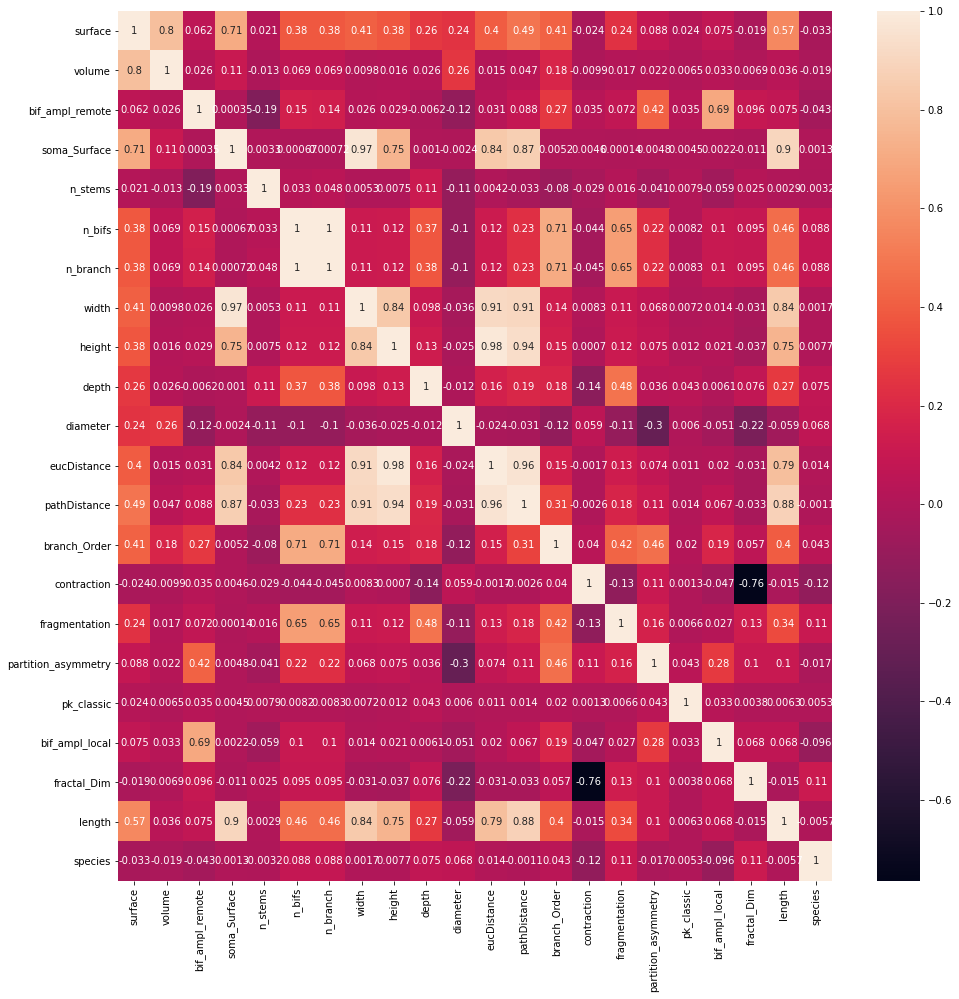

In [50]:
#Because these features are derived from initial measures, it makes sense that some are redundant
plt.figure(figsize=(16,16))
sns.heatmap(df.corr(),annot=True);
#These featres had high correlation in the matrix below, so I removed them
del df['eucDistance']
del df['pathDistance']
del df['soma_Surface']


In [51]:
#There are species labels (human,monkey,rat,mouse)
y_species = df['species']
#These are cell type labels (e.g principal cell, glia, pyramidal). Primary cell types are the main ones, while 
#secondary cellt type is a subtype.
y_primary_original_labels = df['primary_cell_type']
y_secondary_original_labels = df['secondary_cell_type']
# I remove the information about all labels, since I will be doing interspecies predicting
X = df.iloc[:, :-3].values

## 1.3 Coding categorial variabes

In [52]:
cell_values = df['primary_cell_type'].value_counts().index.tolist()
print("There are the primary cell type categorial variables (primary_cell_types) that I want to encode")
print(cell_values)

There are the primary cell type categorial variables (primary_cell_types) that I want to encode
['principal cell', 'pyramidal', 'sensory', 'interneuron', 'glia', 'magnopyramidal', 'von economo neuron', 'granule', 'basket', 'stellate', 'lugaro', 'golgi', 'mi1']


In [53]:
#RUN ONLY ONCE - I encode these variables into integers
mapping_primary = {}
for i in range(0,len(cell_values)):
    mapping_primary[cell_values[i]] = i
df['primary_cell_type'] = df['primary_cell_type'].map(mapping_primary) 
y_primary_original_labels = df['primary_cell_type']
df['primary_cell_type'].value_counts()

0     14424
1      2382
2       805
3       690
4       253
5       142
6        29
7        11
9         7
8         7
11        5
10        5
12        1
Name: primary_cell_type, dtype: int64

In [54]:
cell_values = df['secondary_cell_type'].value_counts().index.tolist()
print("There are the secondary cell type categorial variables that I want to encode")
print(cell_values)

There are the secondary cell type categorial variables that I want to encode
['pyramidal', 'none listed', 'induced pluripotent stem cell-(ipsc)-derived', 'principal cell', 'induced neurons', 'ganglion', 'glutamatergic', 'aspiny', 'gabaergic', 'motoneuron', 'astrocyte', 'basket', 'spiny', 'non-fast spiking', 'amacrine', 'bipolar', 'von economo neuron', 'interneuron', 'catecholaminergic', 'neurogliaform', 'nociceptive', 'lung terminal', 'sparsely spiny', 'persistent activity neuron (pan)', 'multipolar', 'intraepidermal nerve fibres (ienfs)', 'rosehip', 'cajal-retzius', 'bitufted', 'fast-spiking', 'induced neural border stem cell']


In [55]:
mapping_secondary = {}
for i in range(0,len(cell_values)):
    mapping_secondary[cell_values[i]] = i
df['secondary_cell_type'] = df['secondary_cell_type'].map(mapping_secondary) 
df['secondary_cell_type'].value_counts()
y_secondary_original_labels = df['secondary_cell_type']
y_secondary_original_labels.value_counts()

0     8226
1     3475
2     2469
3     2423
4      412
5      333
6      274
7      187
8      174
9      155
10     126
11     102
12     101
13      55
14      50
15      25
18      24
17      24
16      24
19      18
20      15
21      13
22       8
24       8
25       8
23       8
26       7
27       6
28       6
29       4
30       1
Name: secondary_cell_type, dtype: int64

## 1.4 Null values removal

In [56]:
#No null values
df.isnull().sum()

surface                0
volume                 0
bif_ampl_remote        0
n_stems                0
n_bifs                 0
n_branch               0
width                  0
height                 0
depth                  0
diameter               0
branch_Order           0
contraction            0
fragmentation          0
partition_asymmetry    0
pk_classic             0
bif_ampl_local         0
fractal_Dim            0
length                 0
species                0
primary_cell_type      0
secondary_cell_type    0
dtype: int64

In [57]:
#I remove all possible -+ inf values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [58]:
#I load y and X again with preprocessing finished
y_species = df['species']
y_primary_original_labels = df['primary_cell_type']
y_secondary_original_labels = df['secondary_cell_type']
X = df.iloc[:, :-2].values

# 2. Data exploration - principal component analysis

Since I have multidimensional data with several class labels, I need an efficient way to represent the data and potentially understand which features are most important

## 2.1 PCA

In [59]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [60]:
#I scale the data with the standard scaler and perform PCA
scaler = StandardScaler()
X_pca = scaler.fit_transform(X)
pca = PCA().fit(X_pca)

In [61]:
#These are the functions that we used in class to better visualize PCA components and explained varaince (I use them below)
def plot_pca_explained_variance(model):

    fig, ax = plt.subplots(figsize=(12, 8))

    pca_components_range = range(len(pca.components_))

    ax.bar(pca_components_range, pca.explained_variance_ratio_, align='center', label='individual explained variance', alpha=0.3,)
    ax.step(pca_components_range, np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance', color='r')

    ax.set_ylabel('Explained variance ratio')
    ax.set_xlabel('Principal components')
    ax.set_xticks(pca_components_range)
    ax.set_xticklabels(np.arange(1, X.shape[1] + 1))
    
    ax.legend()
    plt.tight_layout()
    
def plot_pca_components(model):
    
    fig, ax = plt.subplots(figsize=(12, 12))

    plt.imshow(model.components_.T)
    plt.yticks(range(len(df.columns[:-2])), df.columns[:-2])
    plt.colorbar()
    plt.tight_layout()

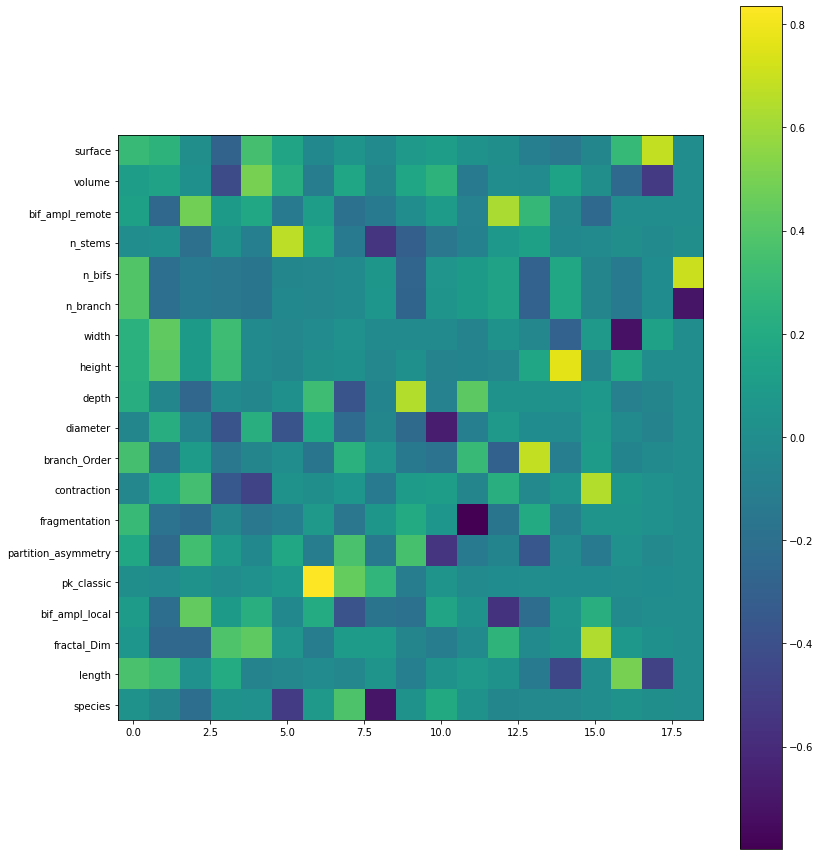

In [62]:
#We see that most components are composed of a combinations, but 
#Some are depending one one feature mostly (their coefficent is highest, while others are lower)
plot_pca_components(pca)


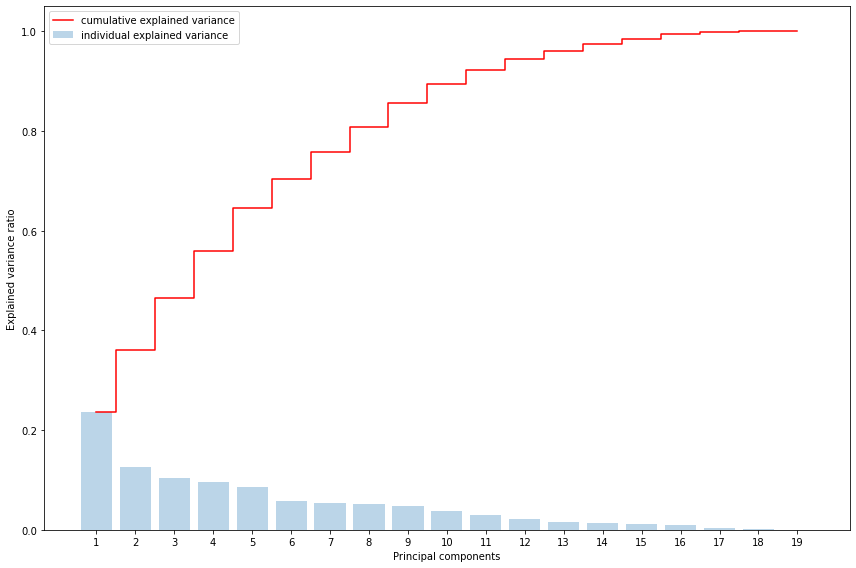

In [63]:
#Essentially, if needed, I may drop about half of features to explain 90% of variance in the data
#I will not do this since <20 feature space is not so large, nor computationally expensive
plot_pca_explained_variance(pca)

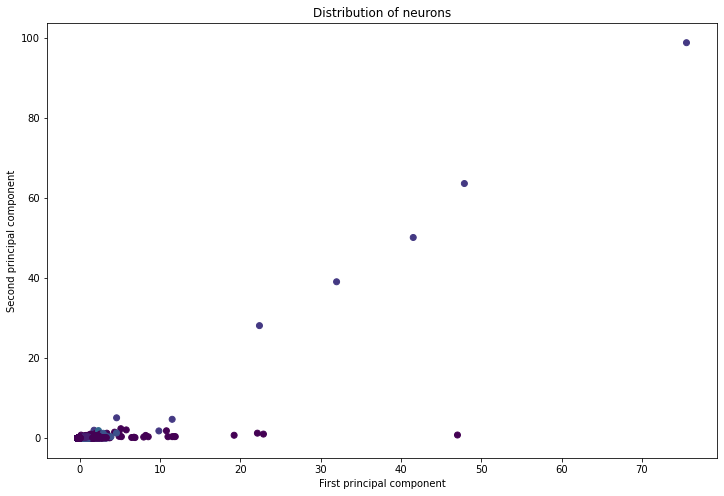

In [65]:
# This is the final visualization based on the two components and using species label. 
# It can be roughly seen that there is some separation, which shows promise to continue
x_1  = [X_pca[i][0] for i in range(0,len(X_pca))]
x_2  = [X_pca[i][1] for i in range(0,len(X_pca))]
plt.figure(figsize=(12,8))
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title("Distribution of neurons")
plt.scatter(x_1,x_2,c=y_primary_original_labels,cmap='viridis');

## 2.2 Validity check - Are classes similar in different datasets (species)?
Since I don't have expert assesment nor a quantity that tells the similarity of interspecies neurons, I need to somehow confirm that these classes used for individual species also apply to other species. 

I will do this by assesing them by clustering methods. First I will perform clustering on all datasets to choose the best algorithm and aferwards, I will perform them on class by class to see if they remain one cluster or they get separated.


In [66]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score


### 2.2.1 Comparison of clustering algorithims
Random labelings have an Adjusted Rand Score and Mutual Inofrmation close to 0.0, while 1.0 stands for perfect match.
I will use these measure to see how well the clusterting algorithms perform compared to the original labels.

### 2.2.2 K-means

In [745]:
n_clusters_list = list(range(1,35))
results_primary_rand = []
results_secondary_rand = []
results_primary_mutual_info = []
results_secondary_mutual_info = []
for n_clusters in n_clusters_list:
    y_kmeans = KMeans(n_clusters=n_clusters).fit_predict(X_pca)
    results_primary_rand.append(adjusted_rand_score(y_primary_original_labels,y_kmeans))
    results_secondary_rand.append(adjusted_mutual_info_score(y_primary_original_labels,y_kmeans))
    results_primary_mutual_info.append(adjusted_rand_score(y_secondary_original_labels,y_kmeans))
    results_secondary_mutual_info.append(adjusted_mutual_info_score(y_secondary_original_labels,y_kmeans))



The number of original clusters (labels) for primary cell types is 13
The number of original clusters (labels) for secondary cell types is 31


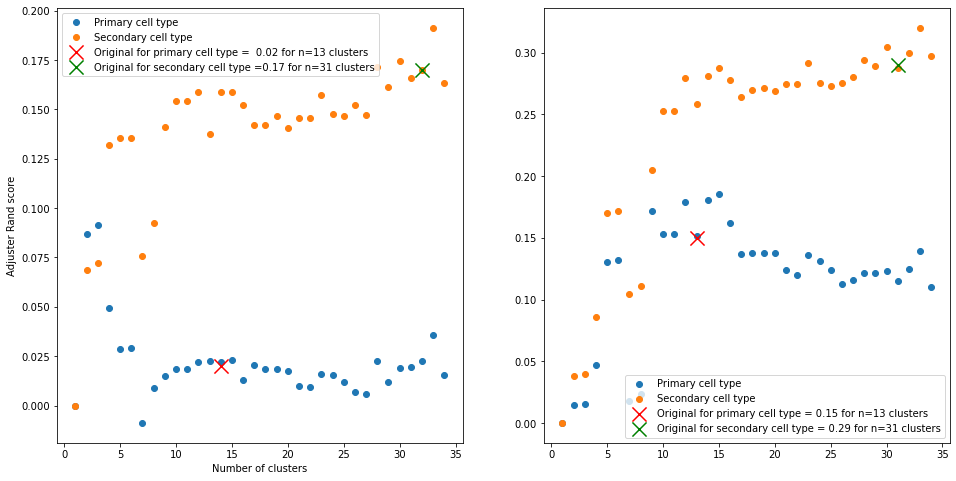

In [746]:
print('The number of original clusters (labels) for primary cell types is ' + str(len(set(y_primary_original_labels))))
print('The number of original clusters (labels) for secondary cell types is ' + str(len(set(y_secondary_original_labels))))
index_of_original_p = len(set(y_primary_original_labels))
rand_primary_o = np.round(results_primary_rand[index_of_original_p],2)
index_of_original_s = len(set(y_secondary_original_labels))
rand_secondary_o = np.round(results_secondary_rand[index_of_original_s],2)

plt.figure(figsize = (16,8))
plt.subplot(121)
plt.xlabel('Number of clusters')
plt.ylabel('Adjuster Rand score')
plt.scatter(n_clusters_list,results_primary_rand,label = 'Primary cell type')
plt.scatter(n_clusters_list,results_secondary_rand,label= 'Secondary cell type')
plt.scatter(n_clusters_list[index_of_original_p],rand_primary_o,
            color='r',label = 'Original for primary cell type =  ' + str(rand_primary_o)
            + ' for n=' + str(len(set(y_primary_original_labels))) + ' clusters',marker='x',s=200)
plt.scatter(n_clusters_list[index_of_original_s],rand_secondary_o,
            color='g',label = 'Original for secondary cell type =' + str(rand_secondary_o) 
            + ' for n=' + str(len(set(y_secondary_original_labels))) + ' clusters',marker='x',s=200)


index_of_original_p = len(set(y_primary_original_labels))-1
mutual_info_primary_o = np.round(results_primary_mutual_info[index_of_original_p],2)
index_of_original_s = len(set(y_secondary_original_labels))-1
mutual_info_secondary_o = np.round(results_secondary_mutual_info[index_of_original_s],2)
plt.legend();

plt.subplot(122)
plt.scatter(n_clusters_list,results_primary_mutual_info,label = 'Primary cell type')
plt.scatter(n_clusters_list,results_secondary_mutual_info,label= 'Secondary cell type')
plt.scatter(n_clusters_list[index_of_original_p],mutual_info_primary_o,
            color='r',label = 'Original for primary cell type = ' + str(mutual_info_primary_o)
            + ' for n=' + str(len(set(y_primary_original_labels))) + ' clusters',marker='x',s=200)
plt.scatter(n_clusters_list[index_of_original_s],mutual_info_secondary_o,
            color='g',label = 'Original for secondary cell type = ' + str(mutual_info_secondary_o) 
            + ' for n=' + str(len(set(y_secondary_original_labels))) + ' clusters',marker='x',s=200)
plt.legend();

### 2.2.3 Agglomerative Clustering

In [67]:
n_clusters_list = list(range(1,35))
results_primary_rand = []
results_secondary_rand = []
results_primary_mutual_info = []
results_secondary_mutual_info = []
for n_clusters in n_clusters_list:
    ac = AgglomerativeClustering(n_clusters=n_clusters,
                                 affinity='euclidean',
                                 linkage='single')
    y_agg = ac.fit_predict(X_pca)
    results_primary_rand.append(adjusted_rand_score(y_primary_original_labels,y_agg))
    results_secondary_rand.append(adjusted_mutual_info_score(y_primary_original_labels,y_agg))
    results_primary_mutual_info.append(adjusted_rand_score(y_secondary_original_labels,y_agg))
    results_secondary_mutual_info.append(adjusted_mutual_info_score(y_secondary_original_labels,y_agg))

The number of original clusters (labels) for primary cell types is 13
The number of original clusters (labels) for secondary cell types is 31


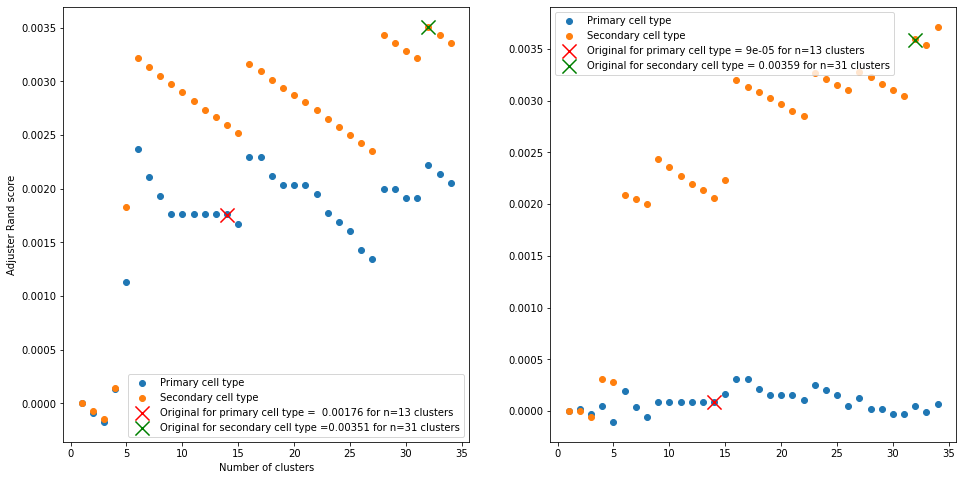

In [76]:
print('The number of original clusters (labels) for primary cell types is ' + str(len(set(y_primary_original_labels))))
print('The number of original clusters (labels) for secondary cell types is ' + str(len(set(y_secondary_original_labels))))
index_of_original_p = len(set(y_primary_original_labels)) 
rand_primary_o = np.round(results_primary_rand[index_of_original_p],5)
index_of_original_s = len(set(y_secondary_original_labels)) 
rand_secondary_o = np.round(results_secondary_rand[index_of_original_s],5)

plt.figure(figsize = (16,8))
plt.subplot(121)
plt.xlabel('Number of clusters')
plt.ylabel('Adjuster Rand score')
plt.scatter(n_clusters_list,results_primary_rand,label = 'Primary cell type')
plt.scatter(n_clusters_list,results_secondary_rand,label = 'Secondary cell type')
plt.scatter(n_clusters_list[index_of_original_p],rand_primary_o,
            color='r',label = 'Original for primary cell type =  ' + str(rand_primary_o)
           + ' for n=' + str(len(set(y_primary_original_labels))) + ' clusters',marker='x',s=200)
plt.scatter(n_clusters_list[index_of_original_s],rand_secondary_o,
            color='g',label = 'Original for secondary cell type =' + str(rand_secondary_o) 
            + ' for n=' + str(len(set(y_secondary_original_labels))) + ' clusters',marker='x',s=200)


index_of_original_p = len(set(y_primary_original_labels))
mutual_info_primary_o = np.round(results_primary_mutual_info[index_of_original_p],5)
index_of_original_s = len(set(y_secondary_original_labels))
mutual_info_secondary_o = np.round(results_secondary_mutual_info[index_of_original_s],5)
plt.legend();

plt.subplot(122)
plt.scatter(n_clusters_list,results_primary_mutual_info,label = 'Primary cell type')
plt.scatter(n_clusters_list,results_secondary_mutual_info,label = 'Secondary cell type')
plt.scatter(n_clusters_list[index_of_original_p],mutual_info_primary_o,
            color='r',label = 'Original for primary cell type = ' + str(mutual_info_primary_o)
            + ' for n=' + str(len(set(y_primary_original_labels))) + ' clusters',marker='x',s=200)
plt.scatter(n_clusters_list[index_of_original_s],mutual_info_secondary_o,
           color='g',label = 'Original for secondary cell type = ' + str(mutual_info_secondary_o) 
            + ' for n=' + str(len(set(y_secondary_original_labels))) + ' clusters',marker='x',s=200)
plt.legend();
#There results are poor, since they are near 0

### 2.2.3 DB scan

In [757]:
eps_value_list = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10]
min_samples = 15
labels = []
results_primary_rand = []
results_secondary_rand = []
results_primary_mutual_info = []
results_secondary_mutual_info = []
for eps in eps_value_list:
        db = DBSCAN(eps=eps,
                    metric='euclidean',
                    min_samples = min_samples)
        y_db = db.fit_predict(X_pca)
        labels.append(len(list(set(db.labels_))))
        results_primary_rand.append(adjusted_rand_score(y_primary_original_labels,y_db))
        results_secondary_rand.append(adjusted_mutual_info_score(y_primary_original_labels,y_db))
        results_primary_mutual_info.append(adjusted_rand_score(y_secondary_original_labels,y_db))
        results_secondary_mutual_info.append(adjusted_mutual_info_score(y_secondary_original_labels,y_db))

The number of original clusters (labels) for primary cell types is 13
The number of original clusters (labels) for secondary cell types is 31


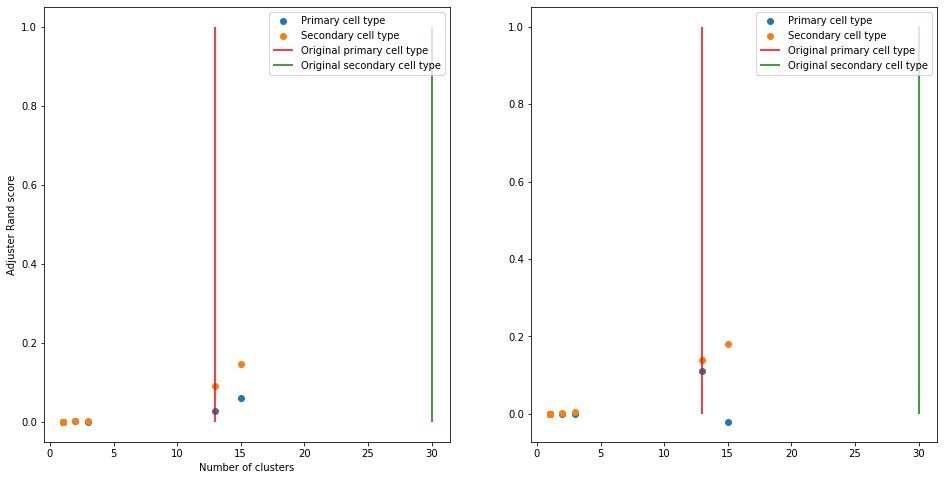

In [758]:
n_clusters_list = list(range(1,200))
print('The number of original clusters (labels) for primary cell types is ' + str(len(set(y_primary_original_labels))))
print('The number of original clusters (labels) for secondary cell types is ' + str(len(set(y_secondary_original_labels))))



plt.figure(figsize = (16,8))
plt.subplot(121)
plt.xlabel('Number of clusters')
plt.ylabel('Adjuster Rand score')
plt.scatter(labels,results_primary_rand,label = 'Primary cell type')
plt.scatter(labels,results_secondary_rand,label = 'Secondary cell type')
plt.vlines(x = index_of_original_p, ymin = 0, ymax = 1, 
           colors = 'red', 
           label = 'Original primary cell type') 
plt.vlines(x = index_of_original_s, ymin = 0, ymax = 1, 
           colors = 'green', 
           label = 'Original secondary cell type') 
 
plt.legend();



plt.subplot(122)
plt.scatter(labels,results_primary_mutual_info,label = 'Primary cell type')
plt.scatter(labels,results_secondary_mutual_info,label = 'Secondary cell type')
plt.legend();
plt.vlines(x = index_of_original_p, ymin = 0, ymax = 1, 
           colors = 'red', 
           label = 'Original primary cell type') 
plt.vlines(x = index_of_original_s, ymin = 0, ymax = 1, 
           colors = 'green', 
           label = 'Original secondary cell type') 
plt.legend()

# Lines show the original number of clusters
# DB scan has not found any clusters for secondary cell types

### 2.2.5 Comments on clustering algorithm comparisons
Agglomerative clustering algorithm doesn't perform well (values near 0) so I will reject it straight away.

K-means seems to find clusters with similar explaining power across all n_cluster values, while DB scan, depending on the eps parameter, seems to find only primary cell clusters, while also having similar Adjusted Rand score and Adjusted Mutual Information scores.

To apply more rigorous testing, I will use K-means, since it may find clusters across all values (even if they are not found in the ground truth data). 
This means that if K-means favors one cluster for filtered data (per cell type), it means that it has rejected other clustering possibilities, so those classes are similar across species.

## 2.3 Which classes should be used, are they comparable across animal species?
Now that I determined the best clustering algorithm, I will use it to compare classes across species. I am doing this because classes may not be same for humans and mouses. For example, human pyramidal neurons may refer to morpohlogically different type than mouse pyramidal neurons. Essentially I want to check this hypothesis:

Classes refer to morphologically similar neurons across species

For each cell type, I am doing this:
1. Filter the dataset by cell type 
2. Remove those with low number of samples
3. Run k-means clustering algorithms for many cluster values
4. Remove those that create more than 1 cluster (this means that the cell type is not so similar across species)

The remaining classes are the one are that I can be sure that correspond to the hypothesis. Moving forward, I will focus only on primary cell types, to simplify the process and increase the chance for models to perform well.

In [724]:
# I start with 13 labels/classes
cell_types_list = list(set(y_primary_original_labels))
cell_types_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Cell type:
0
By design, the number of original clusters (labels) for primary cell types is 1


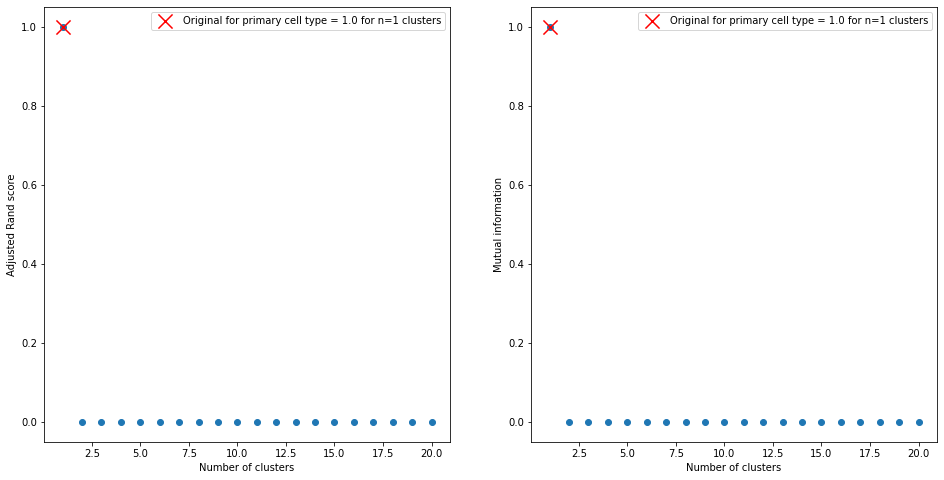

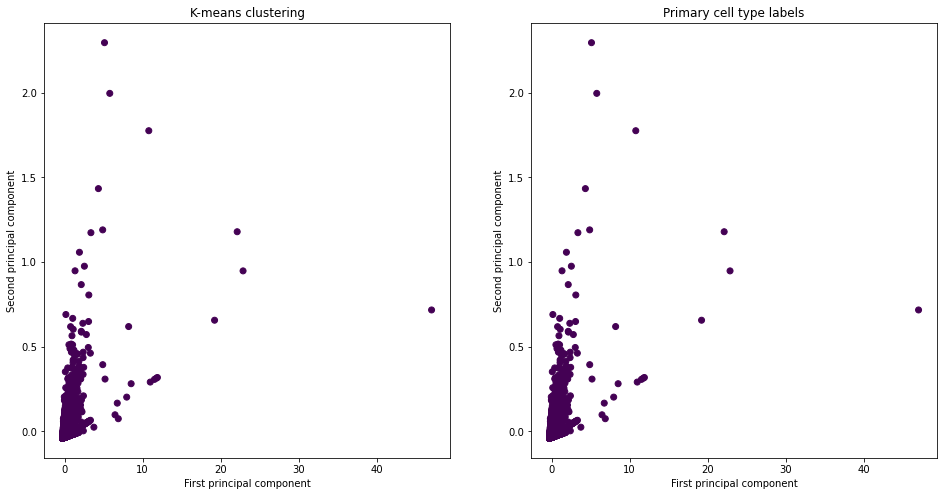

Cell type:
1
By design, the number of original clusters (labels) for primary cell types is 1


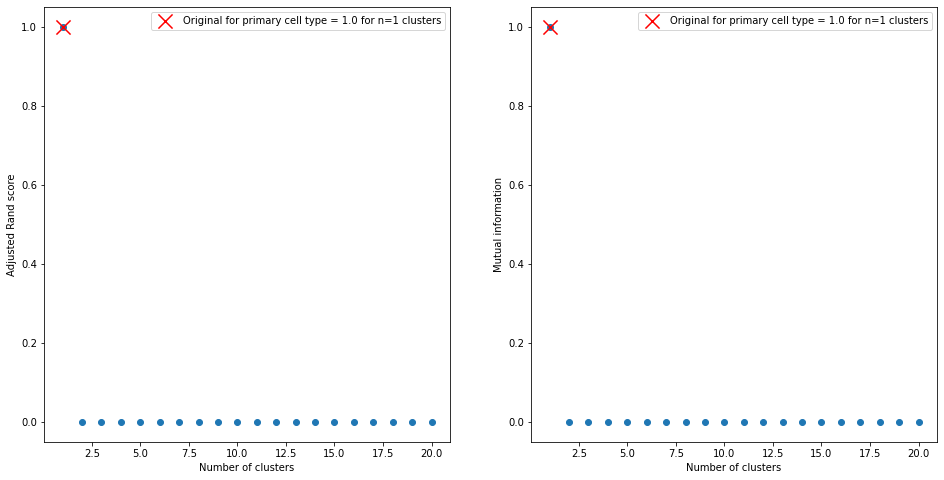

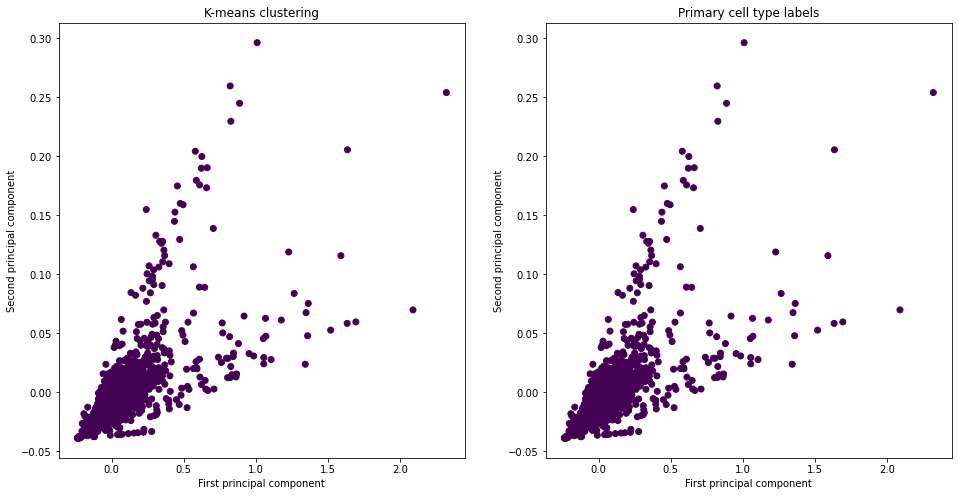

Cell type:
2
By design, the number of original clusters (labels) for primary cell types is 1


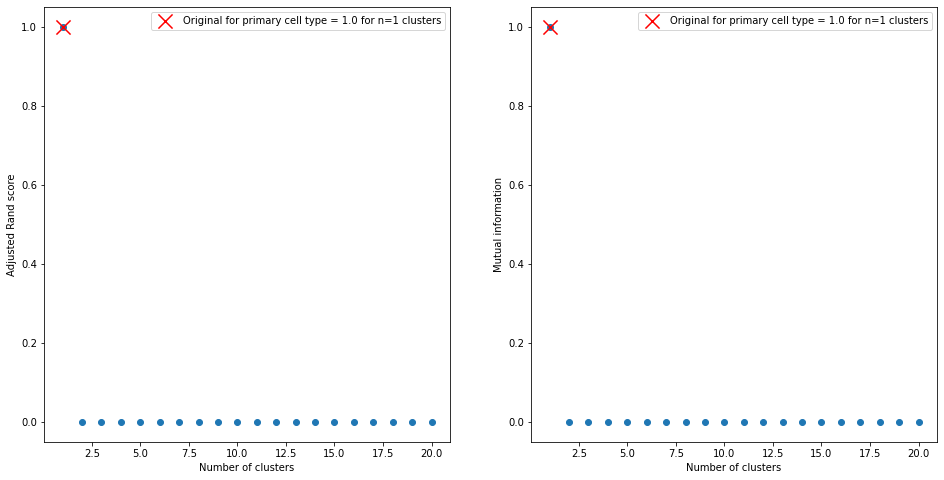

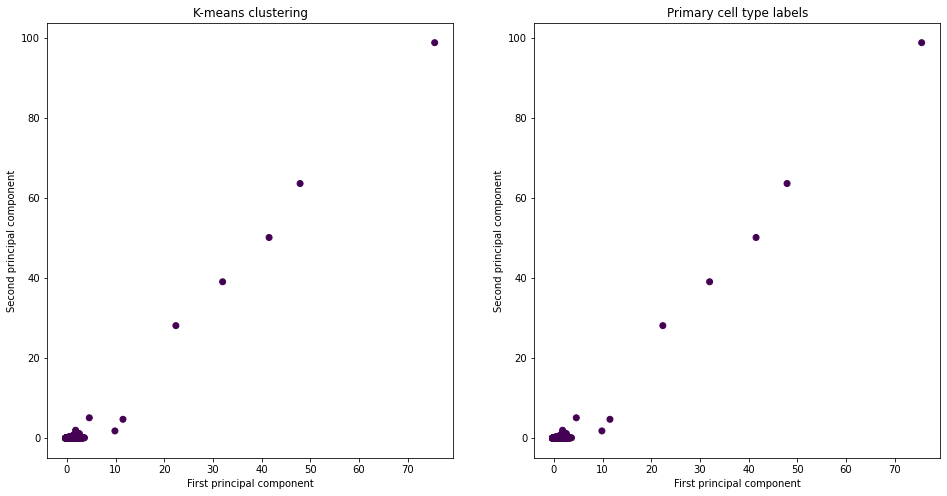

Cell type:
3
By design, the number of original clusters (labels) for primary cell types is 1


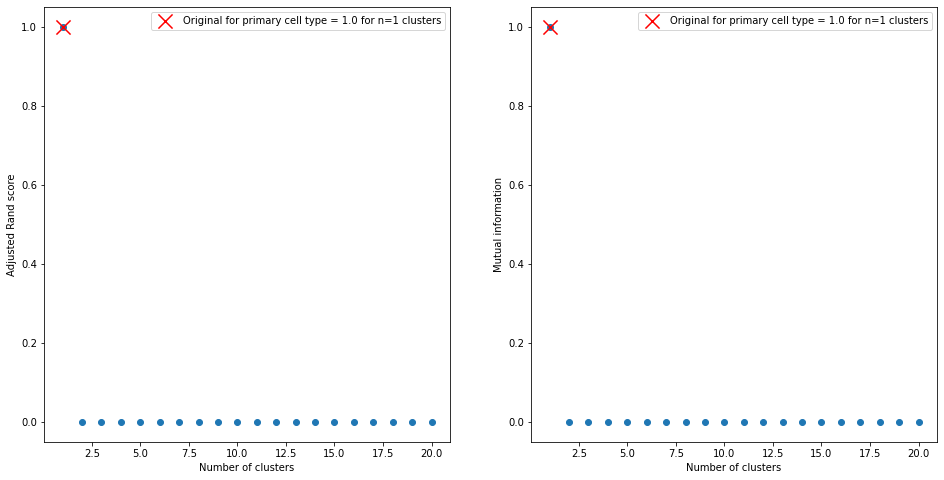

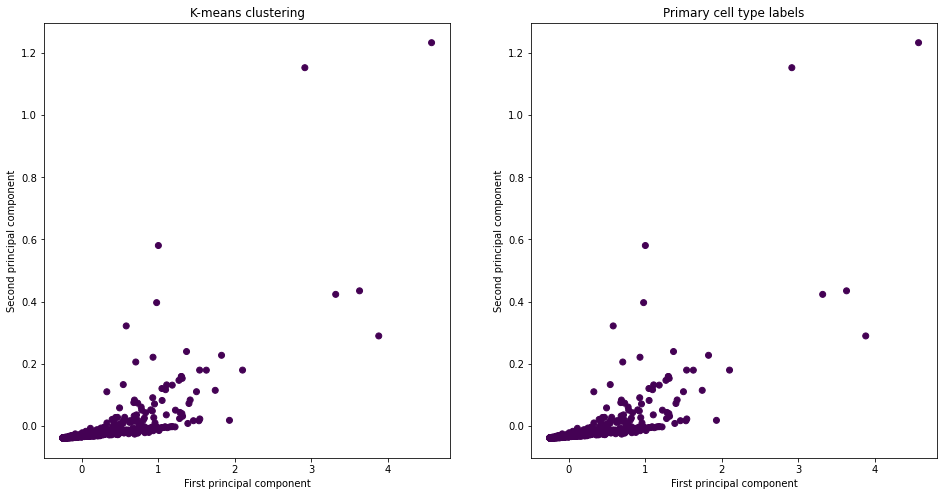

Cell type:
4
By design, the number of original clusters (labels) for primary cell types is 1


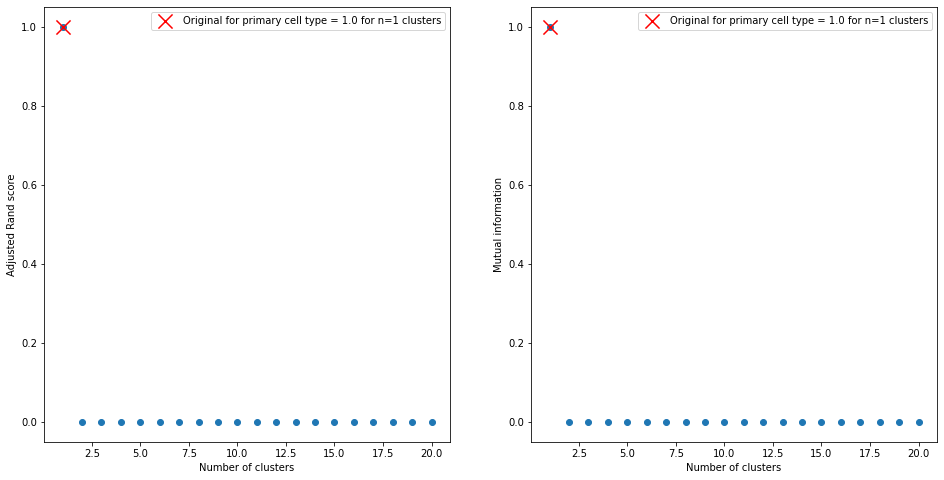

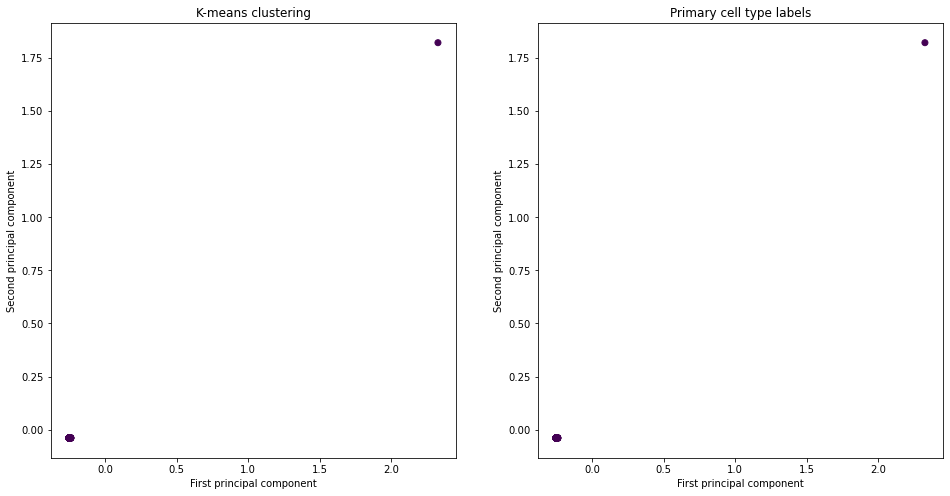

Cell type:
5
By design, the number of original clusters (labels) for primary cell types is 1


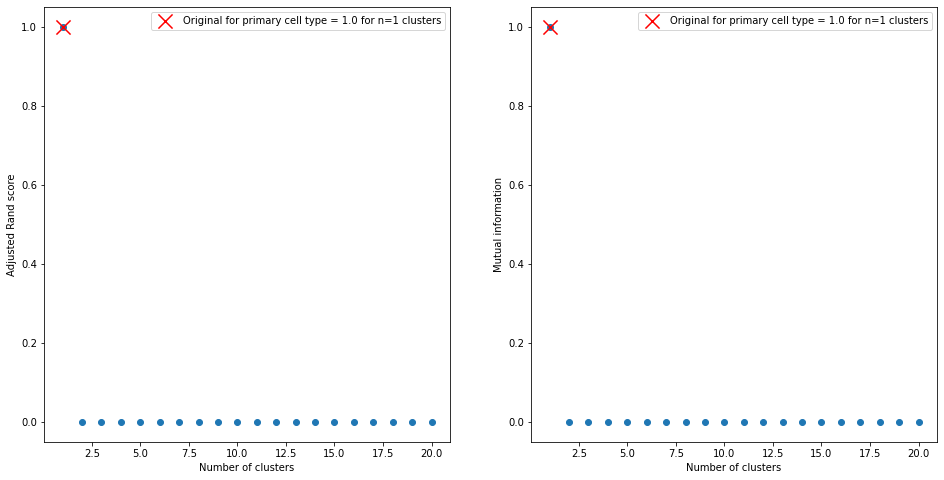

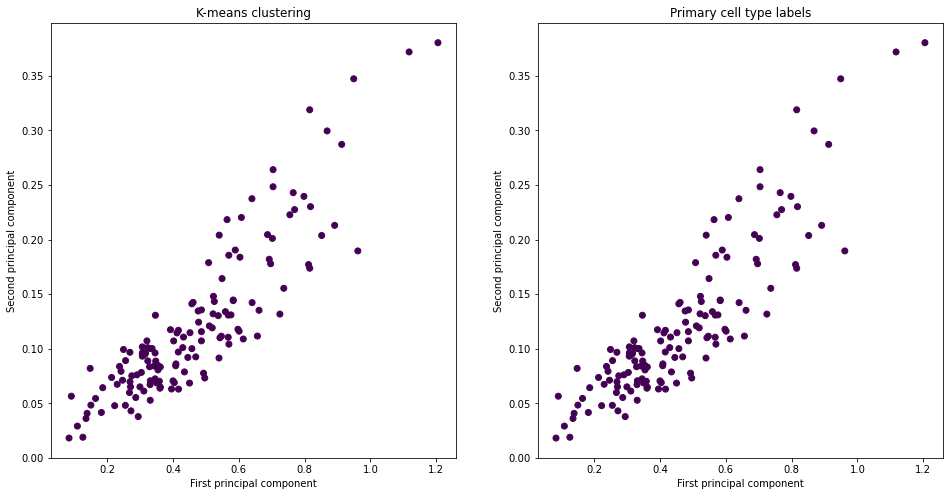

Cell type:
6
By design, the number of original clusters (labels) for primary cell types is 1


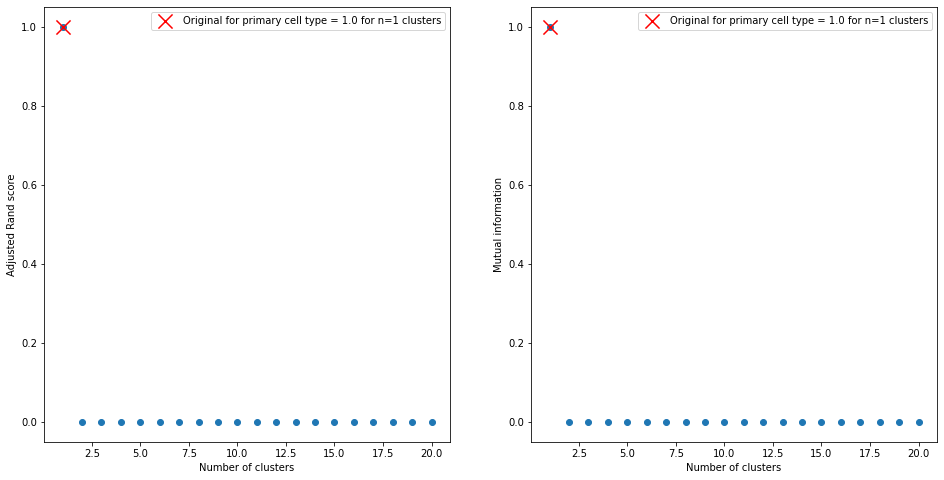

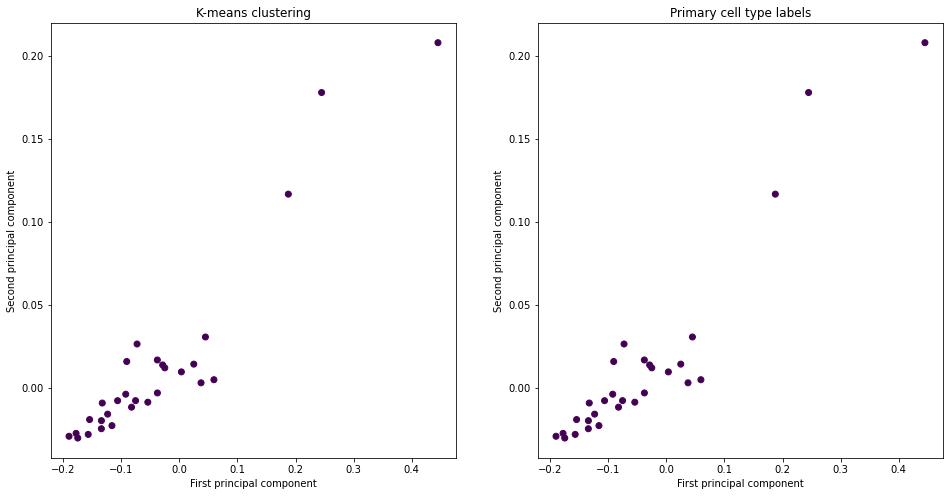

Cell type:
7
Twenty or less samples
Cell type:
8
Twenty or less samples
Cell type:
9
Twenty or less samples
Cell type:
10
Twenty or less samples
Cell type:
11
Twenty or less samples
Cell type:
12
Twenty or less samples


In [725]:
## I prepare lists for the data

cell_types_list = list(set(y_primary_original_labels))
X_pca_cell_types = []
y_pca_cell_types = []
y_pca_species = []
counter = 0
cell_types_to_remove = []

# I perform clustering on each cell type
for cell_type in cell_types_list:
    print('Cell type:')
    print(counter)
    X_type = []
    y_type = []
    y_species_for_type = []
    for i in range(0,len(X_pca)):
        if y_primary_original_labels.iloc[i] == cell_type:
            X_type.append(X_pca[i])
            y_type.append(y_primary_original_labels.iloc[i])
            y_species_for_type.append(y_species.iloc[i])
    
    X_pca_cell_types.append(X_type)
    y_pca_cell_types.append(y_type)
    y_pca_species.append(y_species_for_type)
    
    
    y_species_test = y_pca_species[counter]
    
    X_test = np.array(X_pca_cell_types[counter])
    y_test = y_pca_cell_types[counter]
    counter += 1
    if len(X_test) > 20:
        n_clusters_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    else:
        #Removing classes with twenty or less samples
        print('Twenty or less samples')
        cell_types_to_remove.append(cell_type)
        continue
    #Perform k-means clustering on the filtered data
    results_primary_rand = []
    results_primary_mutual_info = []
    for n_clusters in n_clusters_list:
        y_kmeans = KMeans(n_clusters=n_clusters).fit_predict(X_test)
        results_primary_rand.append(adjusted_rand_score(y_test,y_kmeans))
        results_primary_mutual_info.append(adjusted_rand_score(y_test,y_kmeans))


    print('By design, the number of original clusters (labels) for primary cell types is ' + str(len(set(y_test))))
    index_of_max_1 = results_primary_rand.index(max(results_primary_rand))
    max_rand_primary = np.round(max(results_primary_rand),2)
    index_of_max_2 = results_primary_mutual_info.index(max(results_primary_mutual_info))
    max_mutual_info = np.round(max(results_primary_mutual_info),2)
    
    y_kmeans = KMeans(n_clusters=1).fit_predict(X_test)
    plt.figure(figsize = (16,8))
    plt.subplot(121)
    plt.xlabel('Number of clusters')
    plt.ylabel('Adjuster Rand score')
    plt.scatter(n_clusters_list,results_primary_rand)
    plt.scatter(n_clusters_list[index_of_max_1],max_rand_primary,
            color='r',label = 'Original for primary cell type = ' + str(results_primary_rand[0]) 
            + ' for n=' + str(n_clusters_list[0])  + ' clusters',marker='x',s=200)
    plt.ylabel("Adjusted Rand score")
    plt.xlabel('Number of clusters')
    plt.legend()
    
    plt.subplot(122)
    plt.scatter(n_clusters_list,results_primary_mutual_info)
    plt.scatter(n_clusters_list[0],max_mutual_info,
            color='r',label = 'Original for primary cell type = ' + str(results_primary_mutual_info[0])
            + ' for n=' + str(n_clusters_list[0]) + ' clusters',marker='x',s=200)
    plt.ylabel("Mutual information")
    plt.xlabel('Number of clusters')
    plt.legend()

    plt.figure(figsize = (16,8))
    plt.subplot(121)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_kmeans)
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.title('K-means clustering')
    plt.subplot(122)
    plt.scatter(X_test[:, 0],X_test[:, 1], c=y_test)
    plt.title('Primary cell type labels')
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    
    plt.show()

All classes passed the test - clustering algorithm hasn't found two or more classes. Therefore, only classes that were removed are those with small number of samples.

In [641]:
#These are the remaining cell types and finall classes that I will use
final_cell_types = list(set(cell_types_list)-set(cell_types_to_remove))
print("Final cell types used for classification")
final_cell_types

Final cell types used for classification


[0, 1, 2, 3, 4, 5, 6]

In [642]:
#I remove the rest from the dataset
for ct_remove in cell_types_to_remove:
    df = df[df['primary_cell_type']!= ct_remove]
df['primary_cell_type'].value_counts()

0    14424
1     2382
2      805
3      690
4      253
5      142
6       29
Name: primary_cell_type, dtype: int64

# 3. Primary cell type classification
Now I will separate the datasets by several species combinations
1. Only human data 
2. Only animal data (monkey, rat, mouse)
3. Only monkey data
4. All data (human and animal)

In [643]:
human_df = df[df['species'] == 0]
monkey_df = df[df['species'] == 1]
animal_df = df[df['species'] != 0]
mixed_df = df

## 3.1 Hyperparameter optimization and preliminary comparison of classifiers

In [654]:
from sklearn.pipeline import Pipeline 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [596]:
# For the purpose of hyparameter optimization, I will use the entire dataset, to obtain best hypeparameters across the species 
y = mixed_df['primary_cell_type'].values
X = mixed_df.iloc[:, :-3].values
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25,random_state = 1)

In [598]:
#There are the cell type that I will be using for classification
mixed_df['primary_cell_type'].value_counts()

0    12220
1     2382
3      604
5      142
4      125
6       29
Name: primary_cell_type, dtype: int64

In [599]:
cv = StratifiedKFold(n_splits=5,shuffle=False)

### 3.1.1 Linear SVC 

In [600]:
from sklearn.svm import LinearSVC
pipe = Pipeline([("scaler", StandardScaler()), ("linear_svc", LinearSVC(max_iter=10000))])
pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(max_iter=10000))])

In [601]:
param_grid = {'linear_svc__penalty': ['l2'],'linear_svc__loss':['squared_hinge']}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))


Best cross-validation accuracy: 0.81
Test set score: 0.81
Best parameters: {'linear_svc__loss': 'squared_hinge', 'linear_svc__penalty': 'l2'}


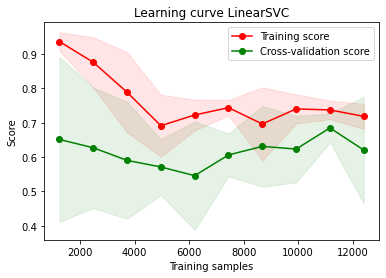

In [92]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve (
     LinearSVC(max_iter=10000,penalty='l2',loss='squared_hinge'), X, y, cv=cv, train_sizes=np.linspace(.1, 1, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.title("Learning curve LinearSVC")
plt.xlabel("Training samples")
plt.ylabel("Score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
plt.legend()

### 3.1.2 Logistic regression

In [86]:
from sklearn.linear_model import LogisticRegression
pipe = Pipeline([("scaler", StandardScaler()), ("logistic_regression", LogisticRegression(solver='liblinear'))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_regression',
                 LogisticRegression(solver='liblinear'))])

In [87]:
param_grid = {'logistic_regression__penalty': ['l1', 'l2'], 'logistic_regression__C' : [0.0001,0.001,0.01,0.1,1,10]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))


Best cross-validation accuracy: 0.83
Test set score: 0.84
Best parameters: {'logistic_regression__C': 10, 'logistic_regression__penalty': 'l1'}


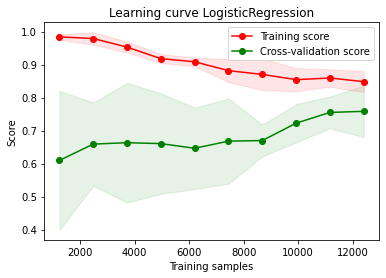

In [93]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve (
     LogisticRegression(solver='liblinear', C=10,penalty='l1'), X, y, cv=cv, train_sizes=np.linspace(.1, 1, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.title("Learning curve LogisticRegression")
plt.xlabel("Training samples")
plt.ylabel("Score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
plt.legend()

### 3.1.3 Decision Trees

In [88]:
from sklearn.tree import DecisionTreeClassifier
pipe = Pipeline([("scaler", StandardScaler()), ("decision_tree", DecisionTreeClassifier())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('decision_tree', DecisionTreeClassifier())])

In [89]:
param_grid = {'decision_tree__criterion': ['gini', 'entropy'],'decision_tree__max_depth':[2,3,4,5,6,8,10,12]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv,refit=True)

grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.94
Test set score: 0.95
Best parameters: {'decision_tree__criterion': 'entropy', 'decision_tree__max_depth': 12}


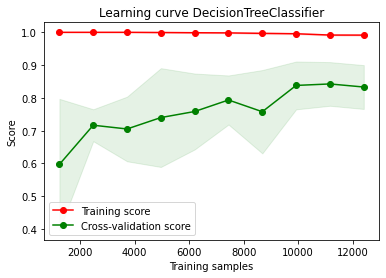

In [94]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve (
     DecisionTreeClassifier(max_depth=12,criterion='entropy'), X, y, cv=cv, train_sizes=np.linspace(.1, 1, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.title("Learning curve DecisionTreeClassifier")
plt.xlabel("Training samples")
plt.ylabel("Score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
plt.legend()

### 3.1.4 K-neighbors

In [90]:
from sklearn.neighbors import KNeighborsClassifier
pipe = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

In [91]:
param_grid = {'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 10, 13, 20, 23, 25, 27, 30]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.95
Test set score: 0.95
Best parameters: {'knn__n_neighbors': 4}


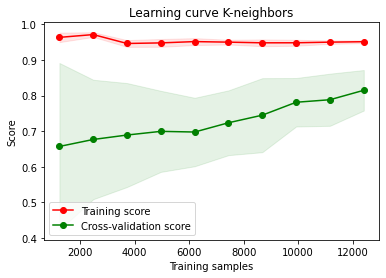

In [95]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve (
    KNeighborsClassifier(n_neighbors=4), X, y, cv=cv, train_sizes=np.linspace(.1, 1, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.title("Learning curve K-neighbors")
plt.xlabel("Training samples")
plt.ylabel("Score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
plt.legend()

### 3.1.5 Comments on hyperparameters

I see that K-neighbors and Decisions trees classifiers tend to overfit (almost perfect and constant training scores) and for this reason, I will not use for the final evaluation.
LinearSVC and Logistic regression do not show impressive scores, but they are good enough try out and evaluate their performances in the next section

## 3.2 Performance evalution on human neuronal data
With chosen classifiers and hyperparameters, now I test the performance of the model on the human data, by training it on different varation of the datasets. For example, I train the datasets on the

In [651]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

trials = 10
scaler = StandardScaler()
#In the end want to change class labels back to their original names
numbers_to_names = dict(map(reversed, mapping_primary.items()))
class_names = [numbers_to_names[i] for i in final_cell_types]

['principal cell',
 'pyramidal',
 'sensory',
 'interneuron',
 'glia',
 'magnopyramidal',
 'von economo neuron']

### Human


### 3.2.1 Linear SVC, training data: human

In [686]:
y_human = human_df['primary_cell_type'].values
X_human = human_df.iloc[:, :-3].values
X_human = scaler.fit_transform(X_human)

accuracy_list = []
recall_list  = []
precision_list = []
f1_list = []
total_y_test = []
total_y_pred = []
for i in range(0,trials):
    X_train, X_test, y_train, y_test = train_test_split(X_human, y_human,test_size = 0.25,random_state = i,stratify=y_human)
    model_1 = LinearSVC(max_iter=10000,penalty='l2',loss='squared_hinge')
    model_1.fit(X_train,y_train)
    y_pred = model_1.predict(X_test)
    
    score_1 = accuracy_score(y_pred,y_test)
    score_2 = recall_score(y_pred,y_test,average='weighted')
    score_3 = precision_score(y_pred,y_test,average='weighted')
    score_4 = f1_score(y_pred,y_test,average='weighted')
    
    accuracy_list.append(score_1)
    precision_list.append(score_2)
    precision_list.append(score_3)
    f1_list.append(score_4)
    total_y_test.append(list(y_test))
    total_y_pred.append(list(y_pred))
    
y_test = [ item for elem in total_y_test for item in elem]
y_pred = [ item for elem in total_y_pred for item in elem]

In [687]:
print("Results for Linear SVC trained on human data, tested on human data")
print(classification_report(y_test,y_pred,target_names = class_names))
accuracy_mean = np.mean(accuracy_list)
accuracy_std = np.std(accuracy_list)
recall_mean = np.mean(precision_list)
recall_std = np.std(precision_list)
precision_mean = np.mean(precision_list)
precision_std = np.std(precision_list)
f1_mean = np.mean(f1_list)
f1_std = np.std(f1_list)
print('Accuracy score is ' +str(np.round(accuracy_mean,2)) + ' +- ' + str(np.round(accuracy_std,2)))
print('Recall score is ' +str(np.round(recall_mean,2)) + ' +- ' + str(np.round(recall_std,2)))
print('Precision score is ' +str(np.round(precision_mean,2)) + ' +- ' + str(np.round(precision_std,2)))
print('F1 score is ' +str(np.round(f1_mean,2)) + ' +- ' + str(np.round(f1_std,2)))


Results for Linear SVC trained on human data, tested on human data
                    precision    recall  f1-score   support

    principal cell       0.94      0.95      0.94     11000
         pyramidal       0.90      0.94      0.92      4910
           sensory       0.98      0.87      0.92       960
       interneuron       0.78      0.40      0.53       420
              glia       0.46      0.12      0.19       100
    magnopyramidal       0.95      0.93      0.94       350
von economo neuron       0.87      0.47      0.61        70

          accuracy                           0.93     17810
         macro avg       0.84      0.67      0.72     17810
      weighted avg       0.92      0.93      0.92     17810

Accuracy score is 0.93 +- 0.01
Recall score is 0.93 +- 0.01
Precision score is 0.93 +- 0.01
F1 score is 0.93 +- 0.01


### 3.2.2 Logistic regression, training data : human

In [682]:
y_human = human_df['primary_cell_type'].values
X_human = human_df.iloc[:, :-3].values
X_human = scaler.fit_transform(X_human)

accuracy_list = []
recall_list  = []
precision_list = []
f1_list = []
total_y_test = []
total_y_pred = []
for i in range(0,trials):
    X_train, X_test, y_train, y_test = train_test_split(X_human, y_human,test_size = 0.25,random_state = i,stratify=y_human)
    model_2 = LogisticRegression(solver='liblinear', C=10,penalty='l1')
    model_2.fit(X_train,y_train)
    y_pred = model_1.predict(X_test)
    
    score_1 = accuracy_score(y_pred,y_test)
    score_2 = recall_score(y_pred,y_test,average='weighted')
    score_3 = precision_score(y_pred,y_test,average='weighted')
    score_4 = f1_score(y_pred,y_test,average='weighted')
    
    accuracy_list.append(score_1)
    precision_list.append(score_2)
    precision_list.append(score_3)
    f1_list.append(score_4)
    total_y_test.append(list(y_test))
    total_y_pred.append(list(y_pred))
    
y_test = [ item for elem in total_y_test for item in elem]
y_pred = [ item for elem in total_y_pred for item in elem]

In [683]:
print("Results for Logistic regression, trained on human data, tested on human data")
print(classification_report(y_test,y_pred,target_names = class_names))
accuracy_mean = np.mean(accuracy_list)
accuracy_std = np.std(accuracy_list)
recall_mean = np.mean(precision_list)
recall_std = np.std(precision_list)
precision_mean = np.mean(precision_list)
precision_std = np.std(precision_list)
f1_mean = np.mean(f1_list)
f1_std = np.std(f1_list)
print('Accuracy score is ' +str(np.round(accuracy_mean,2)) + ' +- ' + str(np.round(accuracy_std,2)))
print('Recall score is ' +str(np.round(recall_mean,2)) + ' +- ' + str(np.round(recall_std,2)))
print('Precision score is ' +str(np.round(precision_mean,2)) + ' +- ' + str(np.round(precision_std,2)))
print('F1 score is ' +str(np.round(f1_mean,2)) + ' +- ' + str(np.round(f1_std,2)))


Results for Logistic regression, trained on human data, tested on human data
                    precision    recall  f1-score   support

    principal cell       0.94      0.95      0.95     11000
         pyramidal       0.90      0.94      0.92      4910
           sensory       0.98      0.88      0.92       960
       interneuron       0.79      0.40      0.53       420
              glia       0.48      0.10      0.17       100
    magnopyramidal       0.96      0.93      0.94       350
von economo neuron       1.00      0.50      0.67        70

          accuracy                           0.93     17810
         macro avg       0.86      0.67      0.73     17810
      weighted avg       0.92      0.93      0.92     17810

Accuracy score is 0.93 +- 0.01
Recall score is 0.93 +- 0.01
Precision score is 0.93 +- 0.01
F1 score is 0.93 +- 0.01


### Animal

### 3.2.3 Linear SVC, training data: animal

In [679]:
y_human = human_df['primary_cell_type'].values
X_human = human_df.iloc[:, :-3].values
X_human = scaler.fit_transform(X_human)

y_animal = animal_df['primary_cell_type'].values
X_animal = animal_df.iloc[:, :-3].values
X_animal = scaler.fit_transform(X_animal)

X_train  = X_animal
y_train = y_animal
X_test = X_human
y_test = y_human

model_1 = LinearSVC(max_iter=10000,penalty='l2',loss='squared_hinge')
model_1.fit(X_train,y_train)

y_pred = model_1.predict(X_test)
print("Results for Linear SVC, trained on animal data, tested on human data")
print(classification_report(y_test,y_pred,target_names = class_names))

Results for Linear SVC, trained on animal data, tested on human data
                    precision    recall  f1-score   support

    principal cell       0.42      0.38      0.40      4397
         pyramidal       0.00      0.00      0.00      1963
           sensory       0.26      0.71      0.39       383
       interneuron       0.47      0.16      0.24       167
              glia       0.02      1.00      0.04        40
    magnopyramidal       0.00      0.00      0.00       142
von economo neuron       0.00      0.00      0.00        29

          accuracy                           0.28      7121
         macro avg       0.17      0.32      0.15      7121
      weighted avg       0.28      0.28      0.27      7121



### 3.2.4 - Logistic regression, training data: animal

In [674]:
y_human = human_df['primary_cell_type'].values
X_human = human_df.iloc[:, :-3].values
X_human = scaler.fit_transform(X_human)

y_animal = animal_df['primary_cell_type'].values
X_animal = animal_df.iloc[:, :-3].values
X_animal = scaler.fit_transform(X_animal)


X_train  = X_animal
y_train = y_animal
X_test = X_human
y_test = y_human
    
model_2 = LogisticRegression(solver='liblinear', C=10,penalty='l1')
model_2.fit(X_train,y_train)
y_pred = model_2.predict(X_test)
 
print("Results for Logistic regression, trained on animal data, tested on human data")
print(classification_report(y_test,y_pred,target_names = class_names))

Results for Logistic regression, trained on animal data, tested on human data
                    precision    recall  f1-score   support

    principal cell       0.33      0.25      0.28      4397
         pyramidal       0.00      0.00      0.00      1963
           sensory       0.15      0.93      0.26       383
       interneuron       0.70      0.17      0.27       167
              glia       0.03      1.00      0.05        40
    magnopyramidal       0.00      0.00      0.00       142
von economo neuron       0.00      0.00      0.00        29

          accuracy                           0.21      7121
         macro avg       0.17      0.34      0.12      7121
      weighted avg       0.23      0.21      0.20      7121



### Monkey

### 3.2.5 Linear SVC, training data: monkey

In [678]:
y_human = human_df['primary_cell_type'].values
X_human = human_df.iloc[:, :-3].values
X_human = scaler.fit_transform(X_human)

X_monkey = monkey_df['primary_cell_type'].values
X_monkey= monkey_df.iloc[:, :-3].values
X_monkey = scaler.fit_transform(X_monkey)

X_train  = X_monkey
y_train = y_monkey
X_test = X_human
y_test = y_human

model_1 = LinearSVC(max_iter=10000,penalty='l2',loss='squared_hinge')
model_1.fit(X_train,y_train)

y_pred = model_1.predict(X_test)

print("Results for Linear SVC, trained on animal data, tested on human data")
print(classification_report(y_test,y_pred,target_names = class_names))

Results for Linear SVC, trained on animal data, tested on human data
                    precision    recall  f1-score   support

    principal cell       0.60      0.71      0.65      4397
         pyramidal       0.49      0.22      0.30      1963
           sensory       0.00      0.00      0.00       383
       interneuron       0.67      0.01      0.02       167
              glia       0.04      0.97      0.07        40
    magnopyramidal       0.00      0.00      0.00       142
von economo neuron       0.00      0.00      0.00        29

          accuracy                           0.50      7121
         macro avg       0.26      0.27      0.15      7121
      weighted avg       0.52      0.50      0.49      7121



### 3.2.5 Logistic regression, training data: monkey

In [677]:
y_human = human_df['primary_cell_type'].values
X_human = human_df.iloc[:, :-3].values
X_human = scaler.fit_transform(X_human)


y_monkey = monkey_df['primary_cell_type'].values
X_monkey = monkey_df.iloc[:, :-3].values
X_monkey= scaler.fit_transform(X_monkey)


X_train  = X_monkey
y_train = y_monkey
X_test = X_human
y_test = y_human
    
model_2 = LogisticRegression(solver='liblinear', C=10,penalty='l1')
model_2.fit(X_train,y_train)
y_pred = model_2.predict(X_test)

print("Results for Logistic regression, trained on monkey data, tested on human data")
print(classification_report(y_test,y_pred,target_names = class_names))

Results for Logistic regression, trained on monkey data, tested on human data
                    precision    recall  f1-score   support

    principal cell       0.62      0.75      0.68      4397
         pyramidal       0.50      0.21      0.30      1963
           sensory       0.00      0.00      0.00       383
       interneuron       0.00      0.00      0.00       167
              glia       0.04      1.00      0.08        40
    magnopyramidal       0.00      0.00      0.00       142
von economo neuron       0.00      0.00      0.00        29

          accuracy                           0.53      7121
         macro avg       0.17      0.28      0.15      7121
      weighted avg       0.52      0.53      0.50      7121



# 4. Conclusion 


## 4.1 Results summary
Below is the summary on thes on the results from the previous questions:
1. Train: human, test: human

Apart from glia and interneurons, every other neuron cell type has had high metric scores, for both classifiers.

2. Train: animal, test: human

Glia and sensory neurons have obtianed high recall scores for both classifiers, while having very low precision scores. For logistic regression, interneurons have shown medium-high precision score.

3. Train: monkey, test: human

For principal and pyramidal cells, medium metric scores were obtained (better for mixed animal training datasets). Interestingly, satsyfing precision score was obtained for interneurons for Linear SVC. Also Glia has had almost perfect recall scores with both classifiers.

## 4.2 Discussion

In order to correctly classify primary neuron types for humans, it's best to use human training data. Even though they have not shown so impressive performance, the models performed well for some classes, showing promise in using cross-species data for training and prediciting. In future research, the focus can be on some specific aspects and features for smaller number of classes, leading to better tuning of the models.